In [1]:
import pandas as pd
import os
import spacy
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
import scipy.stats as stats
import textstat
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import seaborn as sns
from transformers import BertTokenizer, TFBertModel
import random

/Users/matheus/miniconda3/envs/steam-analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [3]:
os.chdir("../..")

We will be working with a Steam store dataset. Each row contains data for a game in the store. We will be restricting or dataset to small scale indie games. Successful games are those with more than 500 reviews. 

By restricting ourselves to the 'about the game' column, we are going to try to find group differences between those games that are successful, acording to the above metric, and those that are not. Our hypothesis is simple: Even though the reasons for a game's success are probably due to deeper factors that are not neatly reflected in the available data, to some extent, emulating the characteristics of a successful game's description could improve our chances of succeding, specially for low-budget, small scale games whose Steam pages are the main source of information for the potential buyer.

In [4]:
steam_df = pd.read_csv("data/raw/games.csv")

In [5]:
steam_df["total_reviews"] = steam_df["Positive"] + steam_df["Negative"]
steam_df["success"] = steam_df["total_reviews"] > 500
steam_success = steam_df[steam_df["success"] == 1]
steam_failure = steam_df[steam_df["success"] == 0]
steam_success_about = steam_success["About the game"]
steam_failure_about = steam_failure["About the game"]
steam_success_about.dropna(inplace=True)
steam_failure_about.dropna(inplace=True)

In [6]:
# Loading a small Spacy model. That will do for now. We will load a large model when it comes to vectorizing words.
nlp = spacy.load("en_core_web_sm")

Starting with a simple frequency analysis. Our goal is breaking the texts into tokens, counting them and classifying them as parts-of-speech. Is there a significant difference in parts-of-speech frequency that could reflect a difference in text style?

In [7]:
def count_pos(text):
    # That's an auxiliary function. It counts the POS.
    doc = nlp(text)
    pos_counts = Counter([token.pos_ for token in doc])
    return pos_counts


def pos_frequency(texts):
    # That's our main function. We want to count the frequencies in each text and them average the whole corpus. Then, we can compare successful to not-successful games.
    all_pos_tags = set()
    for text in texts:
        all_pos_tags.update(count_pos(text).keys())

    all_pos_tags = list(all_pos_tags)

    dfs = []

    for i, text in enumerate(texts):
        pos_counts = count_pos(text)
        doc = nlp(text)
        tokens = [token.text for token in doc]

        # Calculate the frequency of each POS tag
        frequency_dict = {pos: pos_counts[pos] / len(tokens) for pos in all_pos_tags}

        df = pd.DataFrame(frequency_dict, index=[f"text_{i}"]).T

        dfs.append(df)

    # Concatenate all DataFrames along the columns
    frequency_df = pd.concat(dfs, axis=1)

    frequency_df = frequency_df.fillna(0)

    return frequency_df

Applying the function above to successful and unsuccessful games.

In [8]:
failure_sample = random.sample(list(steam_failure_about), 5000)
failure_pos_count = pos_frequency(failure_sample)
failure_pos_count.index = failure_pos_count.index.sort_values()
failure_mean_count = failure_pos_count.mean(axis=1)
failure_std_count = failure_pos_count.std(axis=1)

KeyboardInterrupt: 

In [ ]:
success_sample = random.sample(list(steam_success_about), 5000)
success_pos_count = pos_frequency(success_sample)
success_pos_count.index = success_pos_count.index.sort_values()
success_mean_count = success_pos_count.mean(axis=1)
success_std_count = success_pos_count.std(axis=1)

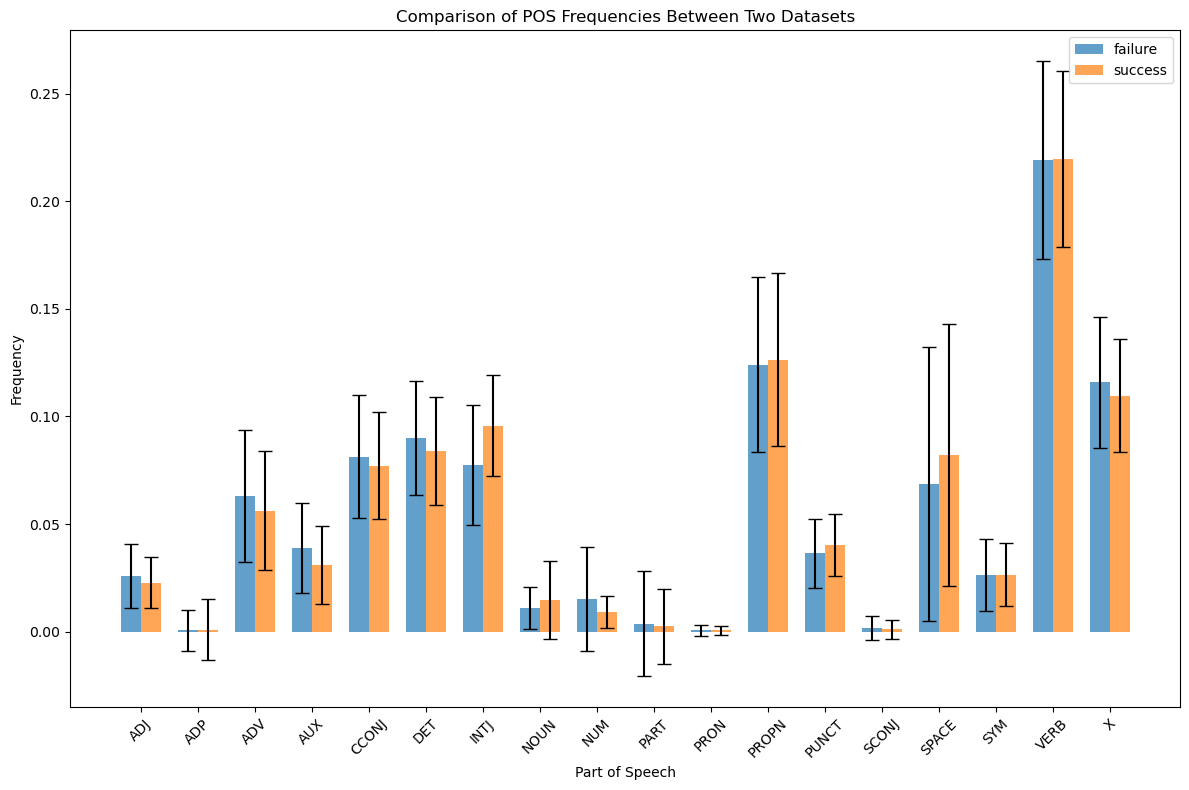

In [ ]:
# Extract POS tags, means, and standard deviations
pos_tags = success_pos_count.index
means1 = failure_mean_count
stds1 = failure_std_count
means2 = success_mean_count
stds2 = success_std_count

bar_width = 0.35
index = np.arange(len(pos_tags))

fig, ax = plt.subplots(figsize=(12, 8))

bar1 = ax.bar(
    index, means1, bar_width, yerr=stds1, label="failure", alpha=0.7, capsize=5
)

bar2 = ax.bar(
    index + bar_width,
    means2,
    bar_width,
    yerr=stds2,
    label="success",
    alpha=0.7,
    capsize=5,
)

ax.set_xlabel("Part of Speech")
ax.set_ylabel("Frequency")
ax.set_title("Comparison of POS Frequencies Between Two Datasets")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(pos_tags, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

Ploting shows that there are not many visible differences of POS frequency. Most of the means are within a standard deviation when compared to the opposite set of texts. We can give a value to the distance between the mean of successful and unsuccessful games by calculating the Z score. Interjections are a little more than half a standard deviation more common in the description for successful games.

In [ ]:
abs((failure_mean_count - success_mean_count) / (failure_std_count)).sort_values(
    ascending=False
)

INTJ     0.657036
AUX      0.370193
NOUN     0.358232
NUM      0.246860
DET      0.240673
PUNCT    0.235854
ADV      0.223211
SPACE    0.210766
X        0.204623
ADJ      0.204450
CCONJ    0.147447
SCONJ    0.076867
PROPN    0.056614
PART     0.051363
ADP      0.038041
PRON     0.033581
VERB     0.010517
SYM      0.006544
dtype: float64

In [ ]:
z_score = 0.38

probability = stats.norm.cdf(z_score)

print(f"The probability of a Z-score of {z_score} or less is {probability:.4f}")

The probability of a Z-score of 0.38 or less is 0.6480


In [ ]:
probability_greater = 1 - probability

print(
    f"The probability of a Z-score greater than {z_score} is {probability_greater:.4f}"
)

The probability of a Z-score greater than 0.38 is 0.3520


We can visualize what half std distance between the mean of two distributions means. There's a big overlap and a high probability that an event inside one of the distributions will fall inside the other distribution, making them hard to distinguish with certainty.

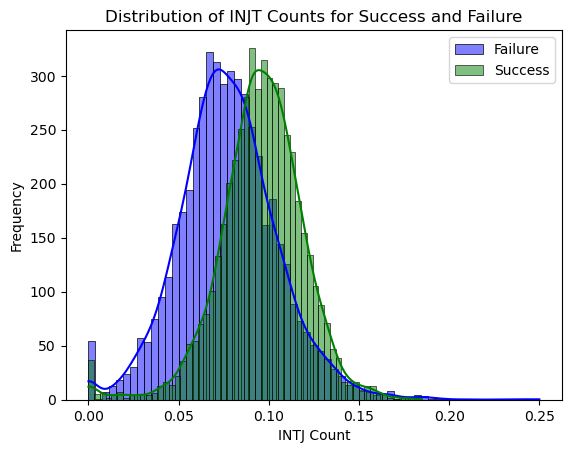

In [ ]:
sns.histplot(failure_pos_count.T["INTJ"], color="blue", label="Failure", kde=True)
sns.histplot(success_pos_count.T["INTJ"], color="green", label="Success", kde=True)
plt.title("Distribution of INJT Counts for Success and Failure")
plt.xlabel("INTJ Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Next, we try to measure text complexity.

In [272]:
texts = success_sample

all_token_counts = []
all_clause_counts = []
all_ttrs = []
all_flesch_reading_eases = []
all_gunning_fogs = []

for text in texts:
    doc = nlp(text)

    token_counts = []
    clause_counts = []
    ttrs = []
    gunning_fogs = []

    for sentence in doc.sents:
        words = [token.text for token in sentence if token.is_alpha]
        unique_words = set(words)
        ttr = len(unique_words) / len(words) if words else 0

        token_counts.append(len(sentence))
        clause_counts.append(
            len(
                [
                    token
                    for token in sentence
                    if token.dep_ == "ccomp" or token.dep_ == "advcl"
                ]
            )
        )
        ttrs.append(ttr)
        gunning_fogs.append(textstat.gunning_fog(sentence.text))

    all_token_counts.append(np.mean(token_counts))
    all_clause_counts.append(np.mean(clause_counts))
    all_ttrs.append(np.mean(ttrs))
    all_gunning_fogs.append(np.mean(gunning_fogs))

mean_token_count = np.mean(all_token_counts)
std_token_count = np.std(all_token_counts)

mean_clause_count = np.mean(all_clause_counts)
std_clause_count = np.std(all_clause_counts)

mean_ttr = np.mean(all_ttrs)
std_ttr = np.std(all_ttrs)

mean_gunning_fog = np.mean(all_gunning_fogs)
std_gunning_fog = np.std(all_gunning_fogs)

print(
    f"Mean number of tokens per sentence: {mean_token_count:.2f} (std: {std_token_count:.2f})"
)
print(
    f"Mean number of subordinate clauses per sentence: {mean_clause_count:.2f} (std: {std_clause_count:.2f})"
)
print(f"Mean Type-Token Ratio (TTR): {mean_ttr:.2f} (std: {std_ttr:.2f})")

print(f"Mean Gunning Fog Index: {mean_gunning_fog:.2f} (std: {std_gunning_fog:.2f})")

KeyboardInterrupt: 

## Vectorizing

We will explore the semantic space now. Here, the adjectives will be taken as an example. We start by loading a large model, as it will be needed to train a better Word2Vec model.

In [12]:
nlp = spacy.load("en_core_web_lg")

In [232]:
def extract_adjectives(text):
    # This function extracts the adjectives in a text and lemmatizes it.
    if pd.isna(text):
        return []
    doc = nlp(text)
    adjectives = [token.lemma_ for token in doc if token.pos_ == "ADJ"]
    return adjectives


def get_adjective_vectors(adjectives):
    vectors = [nlp(word).vector for word in adjectives if word in nlp.vocab]
    return vectors


def calculate_similarity(user_vectors, model_vectors):
    if not user_vectors or not model_vectors:
        return 0.0

    user_vector_avg = np.mean(user_vectors, axis=0)
    model_vector_avg = np.mean(model_vectors, axis=0)

    similarity = cosine_similarity([user_vector_avg], [model_vector_avg])[0][0]
    return similarity

In [242]:
texts = success_sample
all_adjectives = pd.Series(texts).apply(extract_adjectives)
flat_adjectives = [adj for sublist in all_adjectives for adj in sublist]
adjective_counts = Counter(flat_adjectives)
adjective_df_success = pd.DataFrame(
    adjective_counts.items(), columns=["Adjective", "Count"]
)

print(adjective_df_success)

         Adjective  Count
0              new   6702
1     asymmetrical     10
2        different   2472
3          special    751
4          various    762
...            ...    ...
6064     reductive      1
6065       genital      1
6066       flaccid      1
6067        wiggly      1
6068   unappealing      1

[6069 rows x 2 columns]


In [243]:
texts = failure_sample

all_adjectives = pd.Series(texts).apply(extract_adjectives)
flat_adjectives = [adj for sublist in all_adjectives for adj in sublist]
adjective_counts = Counter(flat_adjectives)
adjective_df_failure = pd.DataFrame(
    adjective_counts.items(), columns=["Adjective", "Count"]
)

print(adjective_df_failure)

       Adjective  Count
0           left    118
1           long    334
2        various    795
3      dangerous    305
4        certain    251
...          ...    ...
5255           🙋      1
5256  unplayable      1
5257      spiffy      1
5258     parried      1
5259    limorian      1

[5260 rows x 2 columns]


Let's isolate the top adjectives that occur in one set, but not in the other.

In [253]:
set(adjective_df_success.nlargest(150, "Count")["Adjective"]) - set(
    adjective_df_failure.nlargest(150, "Count")["Adjective"]
)

{'authentic',
 'brutal',
 'competitive',
 'creative',
 'customizable',
 'exclusive',
 'famous',
 'fresh',
 'global',
 'heavy',
 'historical',
 'iconic',
 'incredible',
 'legendary',
 'mighty',
 'military',
 'multi',
 'numerous',
 'official',
 'popular',
 'social',
 'stunning',
 'traditional'}

In [254]:
set(adjective_df_failure.nlargest(150, "Count")["Adjective"]) - set(
    adjective_df_success.nlargest(150, "Count")["Adjective"]
)

{'2d',
 'basic',
 'careful',
 'casual',
 'colorful',
 'cool',
 'crazy',
 'current',
 'cute',
 'friendly',
 'fun',
 'future',
 'hot',
 'like',
 'limited',
 'magic',
 'normal',
 'previous',
 'retro',
 'safe',
 'second',
 'third',
 'unknown'}

We will train the Word2Vec vectorizer on our whole dataset. Then, we can extract the embeddings for our list of adjectives.

In [279]:
pre_processed_reviews = steam_df["About the game"].dropna().apply(simple_preprocess)
vectorizer_model = Word2Vec(
    pre_processed_reviews, vector_size=100, window=5, min_count=1, workers=4
)

In [280]:
# sanity check
print(vectorizer_model.wv.similarity(w1="brazil", w2="argentina"))
print(vectorizer_model.wv.similarity(w1="up", w2="down"))
print(vectorizer_model.wv.similarity(w1="clown", w2="dog"))
print(vectorizer_model.wv.similarity(w1="dog", w2="dog"))

0.78784776
0.1678522
0.5367024
1.0


In [257]:
words_success = {
    "authentic",
    "brutal",
    "competitive",
    "creative",
    "customizable",
    "exclusive",
    "famous",
    "fresh",
    "global",
    "heavy",
    "historical",
    "iconic",
    "incredible",
    "legendary",
    "mighty",
    "military",
    "multi",
    "numerous",
    "official",
    "popular",
    "social",
    "stunning",
    "traditional",
}

In [258]:
words_failure = {
    "2d",
    "basic",
    "careful",
    "casual",
    "colorful",
    "cool",
    "crazy",
    "current",
    "cute",
    "friendly",
    "fun",
    "future",
    "hot",
    "like",
    "limited",
    "magic",
    "normal",
    "previous",
    "retro",
    "safe",
    "second",
    "third",
    "unknown",
}

In [249]:
# Get the vectors for the words in the list and compute the mean vector
vectors_success = [
    vectorizer_model.wv[word]
    for word in filtered_df_succces["Adjective"]
    if word in vectorizer_model.wv
]
mean_vector_success = np.mean(vectors_success, axis=0)

In [250]:
# Get the vectors for the words in the list and compute the mean vector
vectors_failure = [
    vectorizer_model.wv[word]
    for word in filtered_failure_df["Adjective"]
    if word in vectorizer_model.wv
]
mean_vector_failure = np.mean(vectors_failure, axis=0)

Similarity is high between these two vectors because the most common adjectives in a language are used in a wide variety of contexts. 

In [251]:
cosine_similarity(
    mean_vector_success.reshape(1, -1), mean_vector_failure.reshape(1, -1)
)[0][0]

0.9558777

But for those that differ, the degree of similarity is lower. They are not opposites, though.

In [260]:
vectors_success = [
    vectorizer_model.wv[word] for word in words_success if word in vectorizer_model.wv
]
mean_vector_success = np.mean(vectors_success, axis=0)
vectors_failure = [
    vectorizer_model.wv[word] for word in words_failure if word in vectorizer_model.wv
]
mean_vector_failure = np.mean(vectors_failure, axis=0)
cosine_similarity(
    mean_vector_success.reshape(1, -1), mean_vector_failure.reshape(1, -1)
)[0][0]

0.39644107

# Emotion multi-label classifier

In [262]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [264]:
# Load the model and tokenizer
model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


# Define a function to split text into chunks
def split_into_chunks(text, max_length=512):
    tokens = tokenizer(text, return_tensors="pt", truncation=False)
    input_ids = tokens["input_ids"][0]
    chunk_size = max_length - 2  # accounting for special tokens
    chunks = [
        input_ids[i : i + chunk_size] for i in range(0, len(input_ids), chunk_size)
    ]
    return [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

In [ ]:
# Define a function to split text into chunks
def split_into_chunks(text, max_length=512):
    # Tokenize the input text without truncating it
    tokens = tokenizer(text, return_tensors="pt", truncation=False)

    # Extract the input_ids (tokenized ids) from the tokens dictionary
    input_ids = tokens["input_ids"][0]

    # Determine the chunk size by subtracting 2 from max_length to account for special tokens
    chunk_size = max_length - 2

    # Initialize an empty list to hold the chunks
    chunks = []

    # Loop over the input_ids, stepping by chunk_size each time
    for i in range(0, len(input_ids), chunk_size):
        # Create a chunk from the current position to the current position plus chunk_size
        chunk = input_ids[i : i + chunk_size]

        # Decode the chunk back to text and add it to the list of chunks
        chunk_text = tokenizer.decode(chunk, skip_special_tokens=True)
        chunks.append(chunk_text)

    # Return the list of text chunks
    return chunks

In [266]:
# Apply splitting to your texts
texts = random.sample(list(steam_success_about), 500)
chunked_texts_success = [chunk for text in texts for chunk in split_into_chunks(text)]

In [267]:
# Apply splitting to your texts
texts = random.sample(list(steam_failure_about), 500)
chunked_texts_failure = [chunk for text in texts for chunk in split_into_chunks(text)]

In [268]:
pipe = pipeline(
    "text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None
)

In [269]:
success_emotions = pipe(chunked_texts_success)

In [271]:
failure_emotions = pipe(chunked_texts_failure)

In [277]:
# Apply splitting to your texts
texts = steam_failure_about.iloc[:500]
chunked_texts_failure = [chunk for text in texts for chunk in split_into_chunks(text)]

In [278]:
results = pipe(chunked_texts_failure)

In [281]:
scores_df_failure = pd.DataFrame(
    index=pd.DataFrame(results[0]).sort_values(by="label")["label"]
)

In [282]:
for n in range(len(results)):
    scores_df_failure[f"text_n_{n}_score"] = (
        pd.DataFrame(results[n]).sort_values(by="label").set_index("label")["score"]
    )

/var/folders/25/8m9ycrtx2kv84b8szslr4jfc0000gp/T/ipykernel_41289/2589888692.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scores_df_failure[f"text_n_{n}_score"] = (
/var/folders/25/8m9ycrtx2kv84b8szslr4jfc0000gp/T/ipykernel_41289/2589888692.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scores_df_failure[f"text_n_{n}_score"] = (
/var/folders/25/8m9ycrtx2kv84b8szslr4jfc0000gp/T/ipykernel_41289/2589888692.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [283]:
scores_df_failure.T.median().sort_values(ascending=False)

label
neutral           0.560558
approval          0.113490
optimism          0.017025
realization       0.013264
admiration        0.010146
excitement        0.007697
annoyance         0.006164
caring            0.005978
desire            0.004148
joy               0.003995
disapproval       0.003734
curiosity         0.002816
confusion         0.002789
disappointment    0.002119
relief            0.001736
love              0.001583
amusement         0.001483
fear              0.001347
surprise          0.001290
anger             0.001249
sadness           0.001172
pride             0.001151
disgust           0.000934
nervousness       0.000845
gratitude         0.000664
embarrassment     0.000425
grief             0.000380
remorse           0.000312
dtype: float64